In [1]:
import os
import torch
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Use GPU 
os.environ["TOKENIZERS_PARALLELISM"] = "false"  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


#### Count Images in actual folder

In [2]:
det = "Face" 

def count_img(det):
    subfolders = [f.path for f in os.scandir(det) if f.is_dir() and not f.name.startswith(".")]
    
    # Created Lists to store subfolder names and their image counts
    subs = []
    counts = []

    for subfolder in subfolders:
        # Get images with all extensions
        imagess = [f for f in os.scandir(subfolder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
        
        subs.append(os.path.basename(subfolder))  # Store the subfolder name
        counts.append(len(imagess))  # Store the images counts

    return subs, counts



In [ ]:
#To print the count of images
def plot(subs, counts):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(subs, counts, color='skyblue')
    plt.xlabel('Subfolders')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Subfolder')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  
                 str(int(yval)), ha='center', va='bottom', fontsize=10)

    plt.show()

subs, counts = count_img(det)



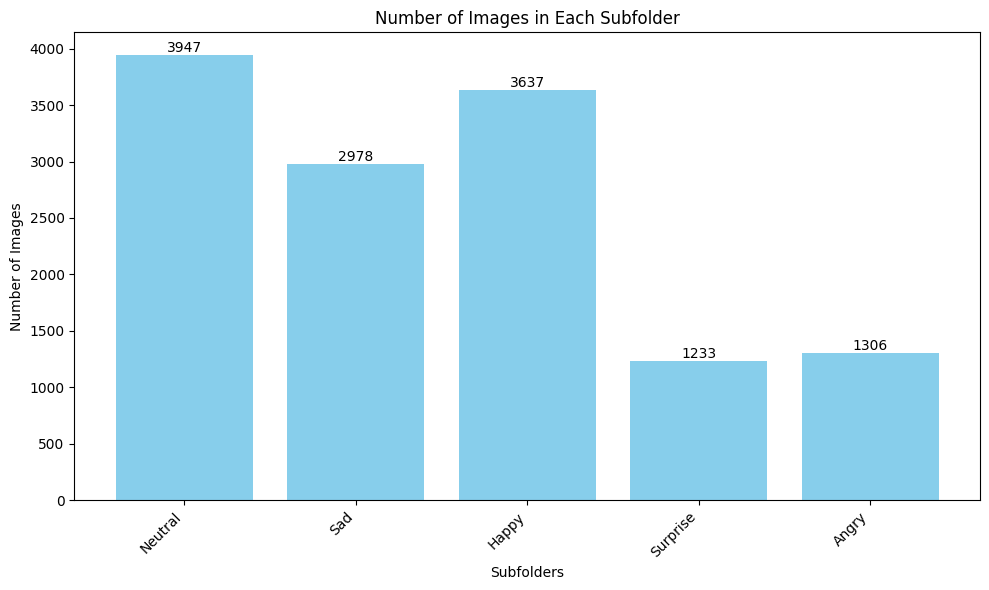

In [3]:
# Plot the results
plot(subs, counts)


#### Remove Excess images

In [4]:
import os
import shutil


det = "Face"  
reduce = ["Neutral", "Sad", "Happy"]
maxi = 2500  # Maximum images I want to have (Total will be around 10K then)

# Create an excess folder
excess_folder = os.path.join(det, "excess_images")
os.makedirs(excess_folder, exist_ok=True)

#THis function will keep the forst 2500 images
def rem(subfolder_path, maxi):
    imagess = sorted(
        [f.path for f in os.scandir(subfolder_path) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
    )

    if len(imagess) > maxi:
        excess_images = imagess[maxi:]  

        # Move excess images to the new folder
        for img in excess_images:
            new_path = os.path.join(excess_folder, os.path.basename(img))
            shutil.move(img, new_path) 

        print(f"Moved {len(excess_images)} images from {subfolder_path} to {excess_folder}")

# Apply to each target subfolder
for subfolder in reduce:
    subfolder_path = os.path.join(det, subfolder)
    if os.path.exists(subfolder_path):
        rem(subfolder_path, maxi)
    else:
        print(f"Subfolder {subfolder} not found!")

print("Image reduction complete.")


Moved 1447 images from Face/Neutral to Face/excess_images
Moved 478 images from Face/Sad to Face/excess_images
Moved 1137 images from Face/Happy to Face/excess_images
Image reduction complete.


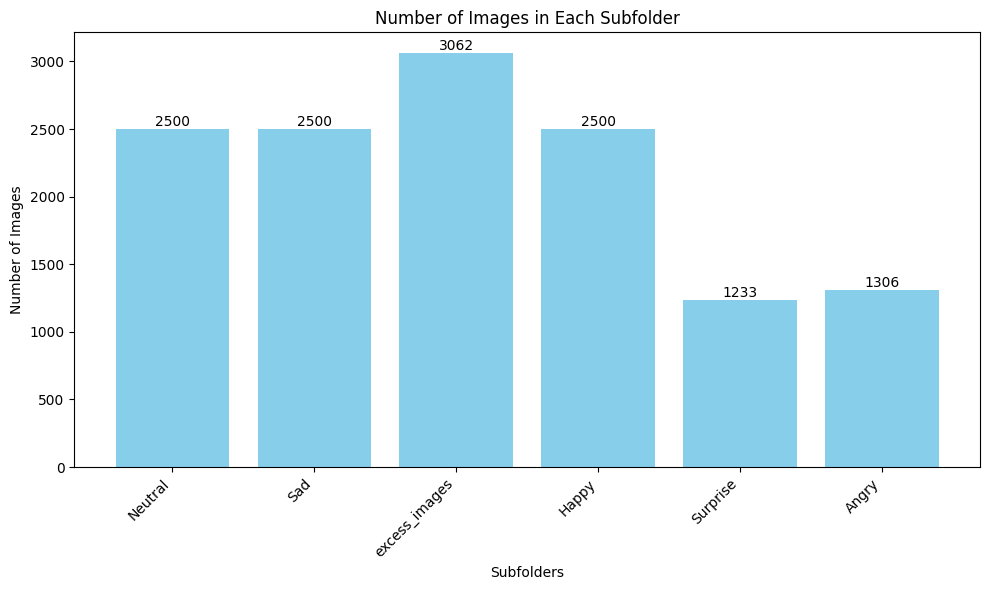

Neutral: 2500 images
Sad: 2500 images
excess_images: 3062 images
Happy: 2500 images
Surprise: 1233 images
Angry: 1306 images


In [6]:
# Count images again after reduction
subs, counts = count_img(det)

# Plot the updated results
plot(subs, counts)

# Print the counts to see in the console
for subfolder, count in zip(subs, counts):
    print(f"{subfolder}: {count} images")


#### To increase the lesser images by Augmentations

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import random
import shutil


det = "Face"  
increase = ["Surprise", "Angry"]
tot = 2500  

# Initialize augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(10, shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=1.0, interpolation=3),
    transforms.ToTensor()
])

# Create an augmentation folder 
def dir_exist(subfolder_name):
    aug_dir = os.path.join(det, subfolder_name, "augmented")
    os.makedirs(aug_dir, exist_ok=True)
    return aug_dir



In [ ]:
def augment_images(subfolder_name, target):
    subfolder_path = os.path.join(det, subfolder_name)
    aug_dir = dir_exist(subfolder_name)
    
    # Get current images
    imagess = [f.path for f in os.scandir(subfolder_path) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
    
    current = len(imagess)
    print(f"Current image count in {subfolder_name}: {current}")
    
    if current >= target:
        print(f"Already have {current} images, no need for augmentation.")
        return

    # Calculate how many images are needed
    images_needed = target - current
    print(f"Need to augment {images_needed} more images.")
    
    for image_path in imagess:
        if images_needed <= 0:
            break
        
        img = Image.open(image_path)
        
        # Augment the image and save to the new folder
        for _ in range(images_needed):
            aug_img = augmentation_transforms(img)
            aug_img_path = os.path.join(aug_dir, f"{os.path.basename(image_path).split('.')[0]}_aug_{random.randint(1000,9999)}.jpg")
            
            # Convert tensor back to Image and save
            aug_img_pil = transforms.ToPILImage()(aug_img)
            aug_img_pil.save(aug_img_path)
            images_needed -= 1
            
            if images_needed <= 0:
                break

    print(f"Augmentation complete for {subfolder_name}. Augmented images saved in {aug_dir}")


In [7]:
# Put augmented images
for subfolder in increase:
    augment_images(subfolder, tot)
    
print("Data augmentation finished.")


Current image count in Surprise: 1233
Need to augment 1267 more images.
Augmentation complete for Surprise. Augmented images saved in Face/Surprise/augmented
Current image count in Angry: 1306
Need to augment 1194 more images.
Augmentation complete for Angry. Augmented images saved in Face/Angry/augmented
Data augmentation finished.


#### Count Images in all files with changes

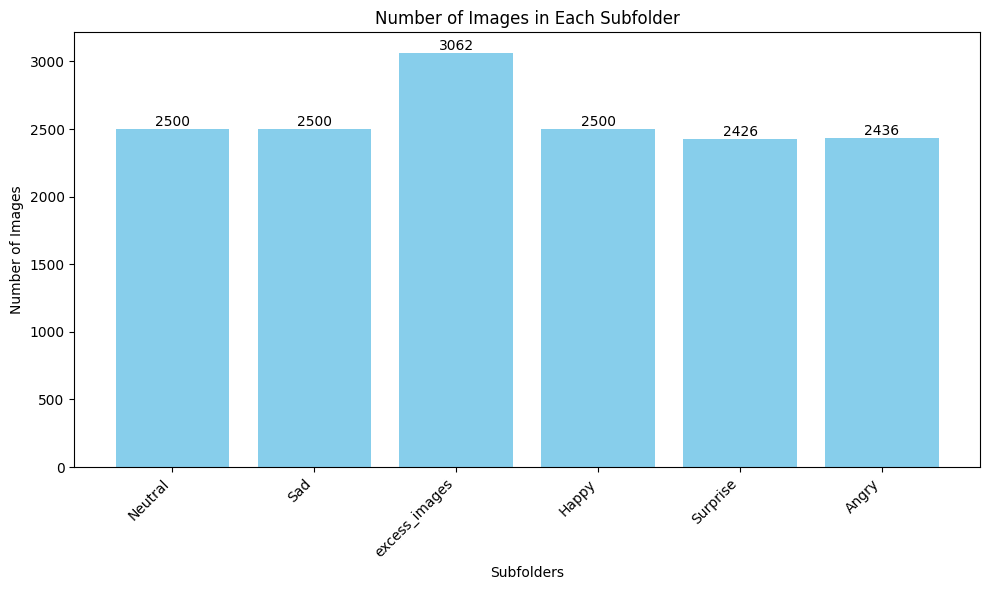

Neutral: 2500 images
Sad: 2500 images
excess_images: 3062 images
Happy: 2500 images
Surprise: 2426 images
Angry: 2436 images


In [10]:
import os

def count_img(det):
    subfolders = [f.path for f in os.scandir(det) if f.is_dir() and not f.name.startswith(".")]
    
    subs = []
    counts = []

    for subfolder in subfolders:
        imagess = [f for f in os.scandir(subfolder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
        
        # Count images in the augmented folder as well
        aug_folder = os.path.join(subfolder, "augmented")
        aug_imgs = []
        if os.path.exists(aug_folder):
            aug_imgs = [f for f in os.scandir(aug_folder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]

        total_images = len(imagess) + len(aug_imgs)  # Sum original and augmented images
        
        subs.append(os.path.basename(subfolder))  
        counts.append(total_images) 

    return subs, counts

# Count images 
subs, counts = count_img(det)

# Plot 
plot(subs, counts)

for subfolder, count in zip(subs, counts):
    print(f"{subfolder}: {count} images")


#### Check Augmented images separately

In [11]:
import os

def count_aug_imgs(det):
    subfolders = [f.path for f in os.scandir(det) if f.is_dir() and not f.name.startswith(".")]
    
    
    subs = []
    aug_img_counts = []

    for subfolder in subfolders:
        
        aug_folder = os.path.join(subfolder, "augmented")
        
        
        aug_imgs = []
        if os.path.exists(aug_folder):
            aug_imgs = [f for f in os.scandir(aug_folder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]

        subs.append(os.path.basename(subfolder))  
        aug_img_counts.append(len(aug_imgs)) 

    return subs, aug_img_counts


subs, aug_img_counts = count_aug_imgs(det)


for subfolder, count in zip(subs, aug_img_counts):
    print(f"Augmented images in {subfolder}: {count} images")


Augmented images in Neutral: 0 images
Augmented images in Sad: 0 images
Augmented images in excess_images: 0 images
Augmented images in Happy: 0 images
Augmented images in Surprise: 1193 images
Augmented images in Angry: 1130 images


#### Move augmented images to Main directory of subfolder

In [14]:
import os
import shutil

def move_aug_imgs(subfolder_name):
    main_sb = os.path.join(det, subfolder_name)
    aug_folder = os.path.join(main_sb, "augmented")
    

    if os.path.exists(aug_folder):
        aug_imgs = [f for f in os.scandir(aug_folder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
        
        # Move each augmented image to the main subfolder
        for img in aug_imgs:
            destination_path = os.path.join(main_sb, os.path.basename(img.path))
            shutil.move(img.path, destination_path) 
            print(f"Moved {os.path.basename(img.path)} to {main_sb}")
        
        # Optionally, remove the 'augmented' folder after moving the images
        shutil.rmtree(aug_folder)
        print(f"Deleted the 'augmented' folder in {subfolder_name}")
    else:
        print(f"No augmented folder found in {subfolder_name}.")

# Define the main folder path and subfolders to process
det = "Face"  # Adjust this as needed
subfolders_to_process = ["Surprise", "Angry"]

# Move the augmented images to the main subfolders
for subfolder in subfolders_to_process:
    move_aug_imgs(subfolder)

print("All augmented images have been moved and the augmented folders deleted.")


Moved cropped_emotions_aug_9603.jpg to Face/Surprise
Moved cropped_emotions_aug_5664.jpg to Face/Surprise
Moved cropped_emotions_aug_9175.jpg to Face/Surprise
Moved cropped_emotions_aug_2420.jpg to Face/Surprise
Moved cropped_emotions_aug_2356.jpg to Face/Surprise
Moved cropped_emotions_aug_5888.jpg to Face/Surprise
Moved cropped_emotions_aug_2272.jpg to Face/Surprise
Moved cropped_emotions_aug_4439.jpg to Face/Surprise
Moved cropped_emotions_aug_5279.jpg to Face/Surprise
Moved cropped_emotions_aug_3053.jpg to Face/Surprise
Moved cropped_emotions_aug_8798.jpg to Face/Surprise
Moved cropped_emotions_aug_1863.jpg to Face/Surprise
Moved cropped_emotions_aug_4217.jpg to Face/Surprise
Moved cropped_emotions_aug_5486.jpg to Face/Surprise
Moved cropped_emotions_aug_5321.jpg to Face/Surprise
Moved cropped_emotions_aug_1701.jpg to Face/Surprise
Moved cropped_emotions_aug_3343.jpg to Face/Surprise
Moved cropped_emotions_aug_7764.jpg to Face/Surprise
Moved cropped_emotions_aug_9056.jpg to Face/Su

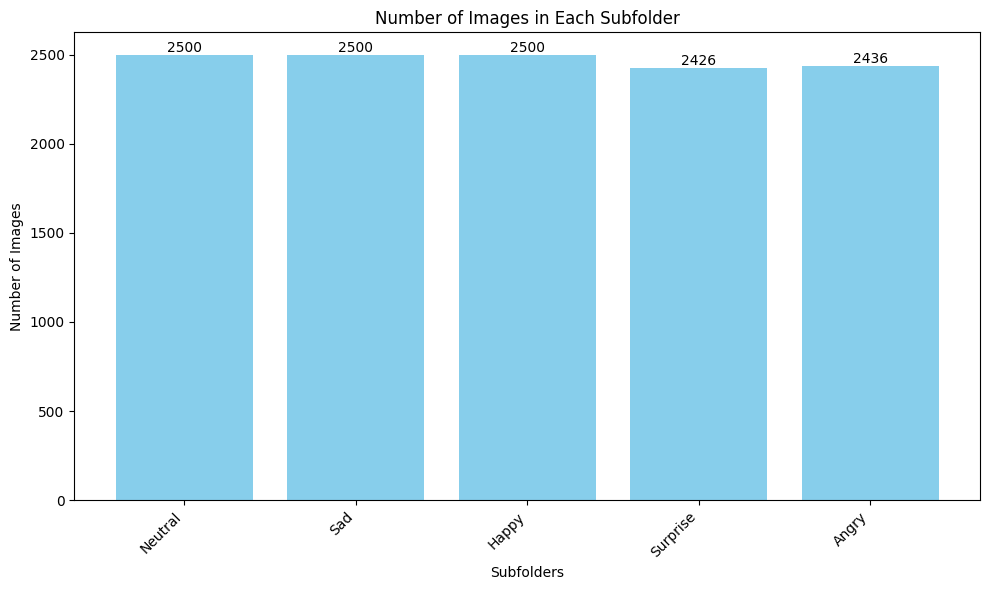

Neutral: 2500 images
Sad: 2500 images
Happy: 2500 images
Surprise: 2426 images
Angry: 2436 images


In [16]:
import os

def count_img(det):
    """ Count the number of images in each subfolder (including moved augmented images). """
    subfolders = [f.path for f in os.scandir(det) if f.is_dir() and not f.name.startswith(".")]
    
    # Initialize lists to store subfolder names and corresponding image counts
    subs = []
    counts = []

    for subfolder in subfolders:
        # Get all image files (jpg, png, etc.) in the subfolder (original and augmented images)
        imagess = [f for f in os.scandir(subfolder) if f.is_file() and f.path.endswith(('jpg', 'png', 'jpeg'))]
        
        subs.append(os.path.basename(subfolder))  # Store the subfolder name
        counts.append(len(imagess))  # Store the number of images

    return subs, counts

# Count images in all subfolders (original + augmented)
subs, counts = count_img(det)

# Plot the updated results (optional)
plot(subs, counts)

# Print the updated counts in the console
for subfolder, count in zip(subs, counts):
    print(f"{subfolder}: {count} images")
